<a href="https://colab.research.google.com/github/AODo23/1221-Darkmatter/blob/main/Supernova_O'Dorisio_10_30_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np #Here we import our handy astropy tools to help us keep our code concise
import matplotlib.pyplot as plt

In [ ]:
import astropy.io.ascii # We now upload our data from NASA ADS on supernovae
import astropy.units as u
import astropy.constants as ac

In [ ]:
from google.colab import files # We now upload our data from NASA ADS on supernovae
uploaded = files.upload()

In [ ]:
dat = astropy.io.ascii.read("Tonry_2003.vot") #The command wil now read the data

Text(0, 0.5, 'Velocity [km/s]')

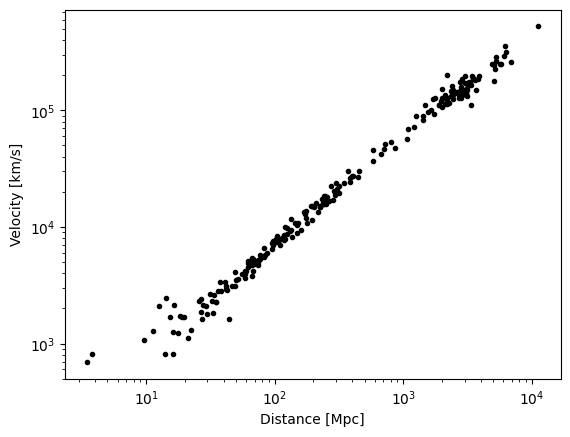

In [ ]:
distance = 10**dat["col8"] / 72.0 * u.mpc #Identifying what data is in which column, we tie this data into python and classify it. After that we plot the values we wish to see visibly
distance_error = (10**(dat["col8"]+dat["col9"]) - 10**dat["col8"]) / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.plot(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, marker=".", color="black", linestyle="none")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

In [ ]:
distance = 10**dat["col8"] / 72.0 * u.mpc #Same thing as above only now we are plotting error bars
velocity = 10**dat["col7"] * u.km / u.s
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

In [ ]:
x = distance.to(u.mpc).value #Here we define new variables to help us calculate
ind = np.where((x > 0) & (x < 700))
z = np.polyfit(distance.to(u.mpc).value[ind], velocity.to(u.km / u.s).value[ind], 1)

In [ ]:
p = np.poly1d(z)

In [ ]:
velocity_model = p(distance.to(u.mpc).value)

In [ ]:
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.plot(distance.to(u.mpc).value, velocity_model, color="grey", linewidth=5)
plt.xlim(0, 700) #Once again we plot errorbars, but for our new value
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")
plt.annotate(r"$H_0$ = {0:5.2f} km/s/Mpc".format(z[0]), xy=(50, 30000))

In [ ]:
x = velocity.to(u.km / u.s).value[ind] #We define new variables again
y = distance.to(u.mpc).value[ind]
yerr = distance_error.to(u.mpc).value[ind]

plt.errorbar(x, y, yerr=yerr, marker=".", color="black", linestyle="none")
# plt.ylim(0, 700)
# plt.xlim(0, 4e4)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]")

In [ ]:
x0 = np.linspace(0, 50000, 500)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([1 / 72.0, 0.0, np.log(1.0)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if 0.0 < m < 0.5 and -100.0 < b < 100.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
! pip install -U emcee

In [ ]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
! pip install corner

In [ ]:
import corner

fig = corner.corner(flat_samples, labels=labels);

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [ ]:
from IPython.display import display, Math # for the past data plots we combine them into one section and display them

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))